In [24]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

## 2M1  
Compute and plot the grix approximate posterior for each of the observations and with a uniform prior

In [10]:
def grid_posterior(obs, total_count, prior, p_grid):
    # compute likelihood at each value in grid
    likelihood = jnp.exp(dist.Binomial(total_count=total_count, probs=p_grid).log_prob(obs))

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / jnp.sum(unstd_posterior)

    return posterior

In [11]:
# define grid
p_grid = jnp.linspace(start=0, stop=1, num=20)

# define prior
prior = jnp.repeat(1, 20)

posteriors = [grid_posterior(y, N, prior, p_grid) for y, N in [(3, 3), (3, 4), (5, 7)]]

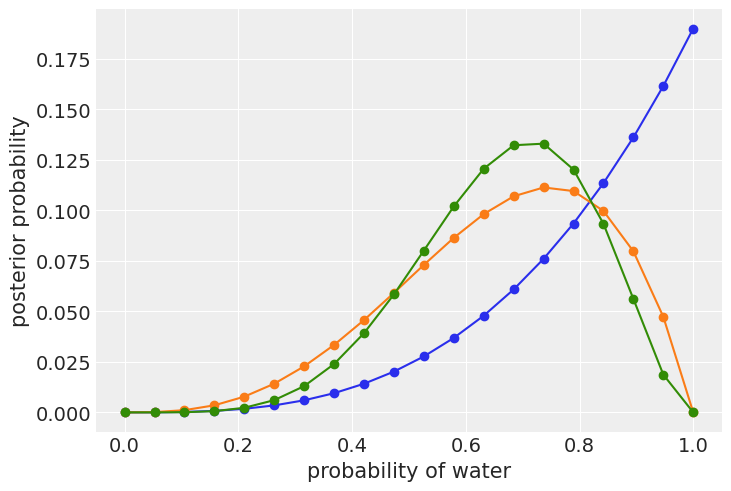

In [12]:
for posterior in posteriors:
    plt.plot(p_grid, posterior, "-o")

plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.show()

## 2M2
Assume prior is zero when p < 0.5 and otherwise uniform

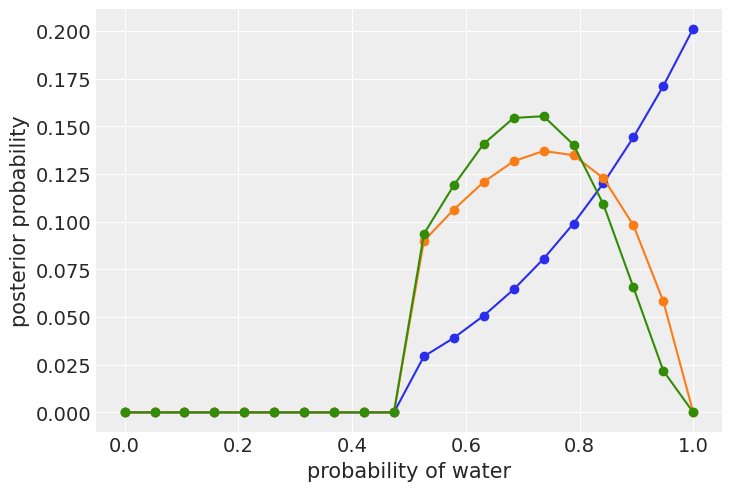

In [15]:
# Update prior
prior = jnp.where(p_grid < 0.5, 0, 1)

for posterior in [grid_posterior(y, N, prior, p_grid) for y, N in [(3, 3), (3, 4), (5, 7)]]:
    plt.plot(p_grid, posterior, "-o")

plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.show()

## 2M3
Two globes. Earth is 70% water, Mars is 100% land

$$
P(E | l)  = \frac{P(E|l)P(E)}{P(E|l)P(E) + P(M|l)P(M)} \\
= \frac{0.3}{0.3 + 1.0} = 0.23
$$

In [36]:
prior = np.array([1/2, 1/2])
likelihood = np.array([0.3, 1])

posterior = likelihood * prior
posterior = posterior / posterior.sum()

print(f"Posterior of earth: {posterior[0]: 0.2f}")

Posterior of earth:  0.23


## 2M4
Three cards {B/B, B/W, W/W}. Card is drawn from a bag, it's black. What's the prob the other side is black = $H_1$

$$
P(H_1|B) = \frac{P(B|H_1)P(H_1)}{P(B|H_1)P(H_1)+P(B|H_0)P(H_0)} \\
= \frac{1 \cdot 1/3}{1 \cdot 1/3 + 1/4 \cdot 2/3} = \frac{4/12}{6 / 12} = 2/3
$$

In [33]:
prior = np.array([1, 1, 1])
likelihood = np.array([2, 1, 0])

posterior = likelihood * prior
posterior = posterior / posterior.sum()

print(f"Posterior of a black/black card: {posterior[0]: 0.2f}")

Posterior of a black/black card:  0.67


## 2M5
Four cards {B/B, B/B, B/W, W/W}

$$
P(H_1|B) = \frac{1 \cdot 2/4}{1 \cdot 2/4 + 1/4 \cdot 2/4} = \frac{8/16}{10/16} = 8/10
$$

In [34]:
prior = np.array([1, 1, 1, 1])
likelihood = np.array([2, 2, 1, 0])

posterior = likelihood * prior
posterior = posterior / posterior.sum()

print(f"Posterior of a black/black card: {posterior[0] + posterior[1]: 0.2f}")

Posterior of a black/black card:  0.80


## 2M6
Heavy black ink. Three cards {B/B, B/W, W/W}. Prior = [1/6, 2/6, 3/6]

$$
P(H_1|B) = \frac{1 \cdot 1/6}{1 \cdot 1/6 + 1 / 2 \cdot 2/6} = \frac{1/6}{2/6} = 1/2
$$

In [35]:
prior = np.array([1/6, 2/6, 3/6])
likelihood = np.array([2, 1, 0])

posterior = likelihood * prior
posterior = posterior / posterior.sum()

print(f"Posterior of a black/black card: {posterior[0]: 0.2f}")

Posterior of a black/black card:  0.50


## 2M7
Three cards {B/B, B/W, W/W}. Two cards drawn from a bag, black and white. What's the prob the other side of the first card is black

Given two observations we now have a number of possible draws ({1,2}, {1,3}, {2,3}) and impossible draws ({2,1}, {3,1},{3,2}). Because card 2 has both a black and a white side, there's only two ways we could observe {1,2} and {2,3} while there are four ways to observe {1,3}.

In [45]:
prior = np.array([1, 1, 1, 1, 1, 1])
likelihood = np.array([2, 4, 2, 0, 0, 0])

posterior = likelihood * prior
posterior = posterior / posterior.sum()

print(f"Posterior of a black/black card: {posterior[0] + posterior[1]: 0.2f}")

Posterior of a black/black card:  0.75


## 2H1
Two panda species {A,B}. A gives birth to twins 10% of the time, B 20% of the time. A random panda gets twins, what's the probability that the next birth is also twins?

In [126]:
prior = np.array([0.5, 0.5])
likelihood = np.array([0.1, 0.2])

posterior = likelihood * prior
posterior = posterior / posterior.sum()

print(f"Posterior of twins: {np.sum(likelihood * prior): 0.2f}")
print(f"Posterior of twins again: {np.sum(posterior * likelihood): 0.2f}")

Posterior of twins:  0.15
Posterior of twins again:  0.17


## 2H2

In [127]:
print(f"Posterior of species A: {posterior[0]: 0.2f}")

Posterior of species A:  0.33


## 2H3
Same panda births a singleton. What is the probability it is species A?

In [128]:
likelihood = np.array([0.1, 0.2]) * np.array([0.9, 0.8])
posterior = likelihood * prior
birth_posterior = posterior / posterior.sum()
print(f"Posterior of species A: {birth_posterior[0]: 0.2f}")

Posterior of species A:  0.36


## 2H4
A genetic test has the true positive rates {A: 0.8, B: 0.65}. Test returns positive for A.

Probability of species A: 
$$
p(A|T=A) = \frac{p(T=A|A)p(A)}{p(T=A|A)p(A) + p(T=A|B)p(B)} \\
= \frac{0.8}{0.8 + 0.35} = 0.7
$$

In [129]:
prior = np.array([0.5, 0.5])
likelihood = np.array([0.8, 0.35])

posterior = likelihood * prior
posterior = posterior / posterior.sum()
print(f"Posterior of species A: {posterior[0]: 0.2f}")

Posterior of species A:  0.70


Including the previous birth data we get

In [130]:
posterior = posterior * birth_posterior
posterior = posterior / posterior.sum()
print(f"Posterior of species A: {posterior[0]: 0.2f}")

Posterior of species A:  0.56


Another way to calculate the same

In [131]:
prior = birth_posterior
likelihood = np.array([0.8, 0.35])

posterior = likelihood * prior
posterior = posterior / posterior.sum()
print(f"Posterior of species A: {posterior[0]: 0.2f}")

Posterior of species A:  0.56
